In [ ]:
sentences = [
    "king is a strong man", 
    "queen is a wise woman", 
    "boy is a young man", 
    "girl is a young woman", 
    "prince is a young king", 
    "princess is a young queen", 
    "man is strong", 
    "woman is pretty", 
    "prince is a boy will be king", 
    "princess is a girl will be queen"
]

In [ ]:
def getUsefulWords(sentence):
    allWords = sentence.split()
    allDistinctWords = set(allWords)
    uselessWords = {"the","is","be","will","a"}
    allDistinctUsefulWords = list(filter(lambda a: a not in uselessWords, allDistinctWords))
    return allDistinctUsefulWords

In [ ]:
allSentenceWordLists = list(map(lambda s: getUsefulWords(s) , sentences))
allUniqueWords = set([item for sublist in allSentenceWordLists for item in sublist])
def makeHotEncoding(i):
    arr = [0]*len(allUniqueWords)
    arr[i] = 1
    return arr
hotEncodings = {element: makeHotEncoding(i) for i,element in enumerate(allUniqueWords)} 
print(hotEncodings)

In [ ]:
def getNeighbors(items):
    neighbors = []
    if len(items) == 1:
        return neighbors
    for i,item in enumerate(items):
        if i != 0:
            neighbors.append([items[i],items[i-1]])
        if i != len(items)-1:
            neighbors.append([items[i],items[i+1]])
    return neighbors

In [ ]:
import tensorflow as tf
allSentenceNeighborLists = list(map(lambda s: getNeighbors(getUsefulWords(s)) , sentences))
allNeighbors = [item for sublist in allSentenceNeighborLists for item in sublist]
print(allNeighbors)
inputs = tf.convert_to_tensor(list(map(lambda s: hotEncodings[s[0]], allNeighbors)),dtype=tf.float32)
outputs = tf.convert_to_tensor(list(map(lambda s:hotEncodings[s[1]], allNeighbors)),dtype=tf.float32)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

vocab_size = len(allUniqueWords)
embedding_dim=2

maxlen = 500
model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    inputs,
    outputs,
    epochs=1000,
    batch_size=512,
    validation_split=0.4)

In [24]:
e = model.layers[0]
weights = e.get_weights()[0]
lookup = list(map(lambda s: {'name':s[0],'x':s[1][0],'y':s[1][1]}, zip(allUniqueWords,weights)))

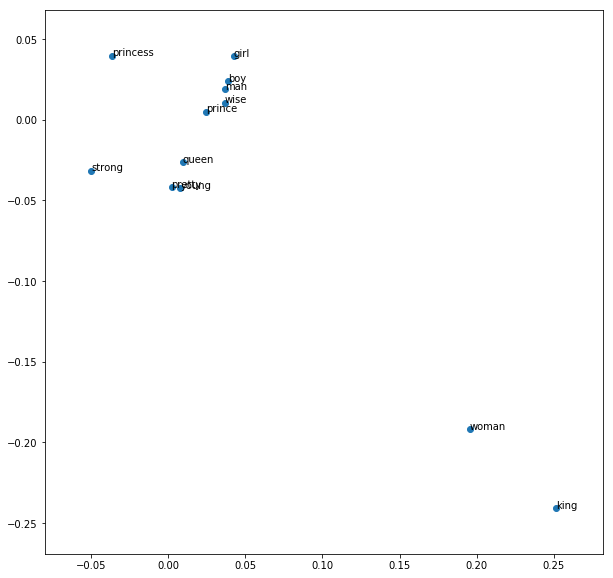

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_min = 0
y_min = 0
x_max = 0
y_max = 0
x_data = []
y_data = []
for e in lookup:
    x_data.append(e['x'])
    y_data.append(e['y'])
    x_min = min(x_min,e['x'])
    y_min = min(y_min,e['y'])
    x_max = max(x_max,e['x'])
    y_max = max(y_max,e['y'])
    ax.annotate(e['name'],(e['x'],e['y']))
x_pad = abs(x_max-x_min)*.1
y_pad = abs(y_max-y_min)*.1
    
plt.xlim(x_min-x_pad,x_max+x_pad)
plt.ylim(y_min-y_pad,y_max+y_pad)
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(x_data,y_data)